# Medicare Part D- by Provider and Drug (2021-2023)

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pip install psycopg2-binary

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.6 MB 5.0 MB/s eta 0:00:01
   -------------------- ------------------- 1.3/2.6 MB 3.2 MB/s eta 0:00:01
   ---------------------------- ----------- 1.8/2.6 MB 3.0 MB/s eta 0:00:01
   ------------------------------------ --- 2.4/2.6 MB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 2.7 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import psycopg2
print("psycopg2 installed successfully!")

psycopg2 installed successfully!


In [3]:
engine = create_engine(
    "postgresql+psycopg2://postgres@localhost:5432/medicare_partd_by_provider_drug_2021_2023",
    connect_args={"password": "Abhiakhi1$"}
)

df = pd.read_sql("SELECT COUNT(*) FROM prescribers_drug_final;", engine)
print(df)

      count
0  77896261


## 1. Identify top prescribers by total drug cost.

In [4]:
query_1 = """
SELECT prscrbr_npi,PRSCRBR_FIRST_NAME,PRSCRBR_LAST_ORG_NAME,SUM(TOT_DRUG_CST) AS TOTAL_DRUG_COST
FROM prescribers_drug_final
GROUP BY 1,2,3
ORDER BY 4 DESC LIMIT 10;
"""

df1 = pd.read_sql(query_1, engine)
df1

,prscrbr_npi,prscrbr_first_name,prscrbr_last_org_name,total_drug_cost
0,1639279417,Armaghan,Azad,2.434336e+08
1,1356534994,Cedric,Davis,2.092623e+08
2,1649365529,Rushdi,Alul,1.169197e+08
3,1285683755,Hunter,Champion,1.050457e+08
4,1871547596,Elvin,Garcia,1.035002e+08
5,1992764591,Daniel,Bauer,1.019560e+08
6,1265429617,John,Bogdasarian,1.010280e+08
7,1972641074,Marc,Watkins,9.050448e+07
8,1538169388,Stephanie,Han,8.904156e+07
9,1093988669,Abigail,Stocker,8.865376e+07


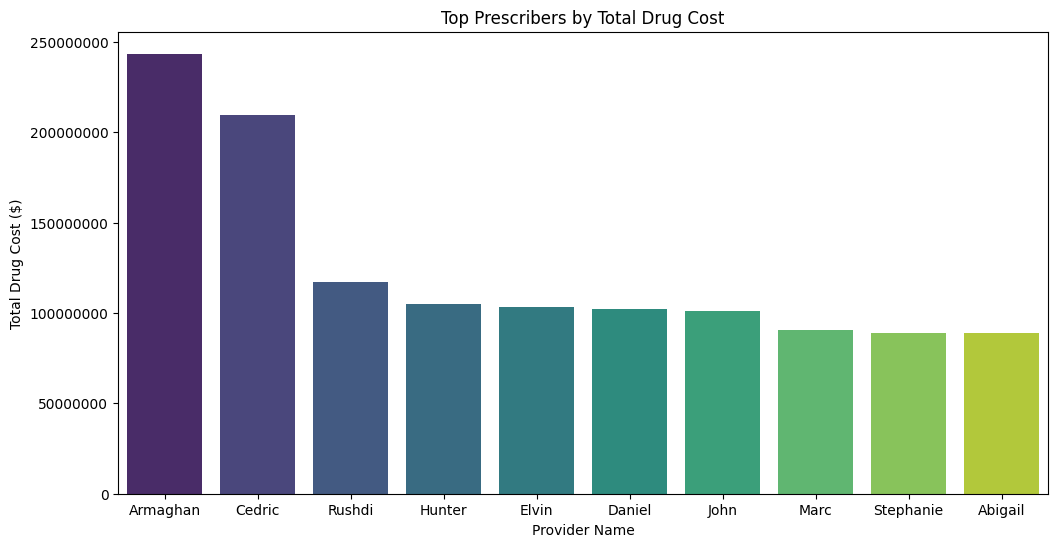

In [5]:
import matplotlib.ticker as mtick

plt.figure(figsize=(12,6))
sns.barplot(y="total_drug_cost", x="prscrbr_first_name", data=df1,hue="prscrbr_first_name",palette="viridis")
plt.title("Top Prescribers by Total Drug Cost")
plt.xlabel("Provider Name")
plt.ylabel("Total Drug Cost ($)")
# Force plain numbers instead of scientific notation
plt.gca().yaxis.set_major_formatter(mtick.ScalarFormatter(useOffset=False))
plt.gca().ticklabel_format(style='plain', axis='y')
plt.show()

## 2. Compare brand vs. generic utilization and costs by provider type.

- If **Brnd_Name = Gnrc_Name**, it’s a **generic** prescription.
- If **Brnd_Name ≠ Gnrc_Name**, it’s a **brand** prescription.

In [27]:
query_2 = """
SELECT 
    Prscrbr_Type,
    SUM(CASE WHEN Brnd_Name <> Gnrc_Name THEN Tot_Clms ELSE 0 END) AS brand_claims,
    SUM(CASE WHEN Brnd_Name = Gnrc_Name THEN Tot_Clms ELSE 0 END) AS generic_claims,
    SUM(CASE WHEN Brnd_Name <> Gnrc_Name THEN Tot_Drug_Cst ELSE 0 END) AS brand_cost,
    SUM(CASE WHEN Brnd_Name = Gnrc_Name THEN Tot_Drug_Cst ELSE 0 END) AS generic_cost,
    ROUND(
    	SUM(CASE WHEN Brnd_Name = Gnrc_Name THEN Tot_Clms ELSE 0 END)::numeric
       /NULLIF(SUM(Tot_Clms),0) * 100, 2) AS pct_generic_claims,
    ROUND(
        SUM(CASE WHEN Brnd_Name <> Gnrc_Name THEN Tot_Clms ELSE 0 END)::numeric
        /NULLIF(SUM(Tot_Clms),0) * 100, 2) AS pct_brand_claims
FROM prescribers_drug_final
GROUP BY Prscrbr_Type
ORDER BY brand_cost DESC;
"""
df2 = pd.read_sql(query_2, engine)
df2

,prscrbr_type,brand_claims,generic_claims,brand_cost,generic_cost,pct_generic_claims,pct_brand_claims
0,Internal Medicine,200154251,768662731,7.533128e+10,1.512292e+10,79.34,20.66
1,Nurse Practitioner,138135312,489378877,7.020499e+10,1.102368e+10,77.99,22.01
2,Family Practice,209605156,834837352,6.162064e+10,1.459158e+10,79.93,20.07
3,Hematology-Oncology,5924966,13021685,3.739144e+10,2.753407e+09,68.73,31.27
4,Cardiology,46377857,133525937,2.765373e+10,2.880497e+09,74.22,25.78
...,...,...,...,...,...,...,...
191,Hearing Instrument Specialist,0,17,0.000000e+00,9.315300e+02,100.00,0.00
192,"Midwife, Lay",0,84,0.000000e+00,7.053500e+02,100.00,0.00
193,Veterinarian,0,24,0.000000e+00,4.369700e+02,100.00,0.00
194,Specialist/Technologist Cardiovascular,0,15,0.000000e+00,8.093200e+02,100.00,0.00


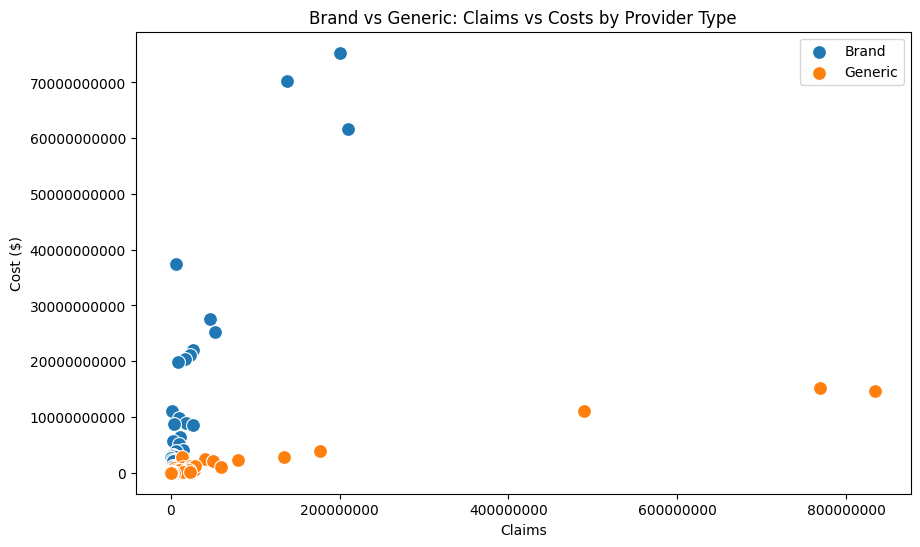

In [36]:
import matplotlib.ticker as mtick


plt.figure(figsize=(10,6))
sns.scatterplot(x="brand_claims", y="brand_cost", data=df2, label="Brand", s=100)
sns.scatterplot(x="generic_claims", y="generic_cost", data=df2, label="Generic", s=100)

plt.title("Brand vs Generic: Claims vs Costs by Provider Type")
plt.xlabel("Claims")
plt.ylabel("Cost ($)")
# Force plain numbers instead of scientific notation
plt.gca().yaxis.set_major_formatter(mtick.ScalarFormatter(useOffset=False))
plt.gca().ticklabel_format(style='plain', axis='y')
plt.gca().ticklabel_format(style='plain', axis='x')
plt.legend()
plt.show()


# 3. Rank specialties by prescribing volume and beneficiary reach.

In [8]:
query_3 = """
WITH speciality AS (
	SELECT Prscrbr_Type, SUM(Tot_Clms) AS total_claims, SUM(tot_benes) AS total_beneficiaries
	FROM prescribers_drug_final
	GROUP BY Prscrbr_Type
)
SELECT Prscrbr_Type,total_claims,total_beneficiaries,
		RANK() OVER(ORDER BY TOTAL_CLAIMS DESC) AS rank_by_claims,
		RANK() OVER(ORDER BY total_beneficiaries DESC) AS rank_by_beneficiaries
FROM SPECIALITY
GROUP BY Prscrbr_Type,total_claims,total_beneficiaries
ORDER BY TOTAL_CLAIMS DESC 
LIMIT 10;
"""
df3 = pd.read_sql_query(query_3,engine)
df3

,prscrbr_type,total_claims,total_beneficiaries,rank_by_claims,rank_by_beneficiaries
0,Family Practice,1044442508,310331356,1,1
1,Internal Medicine,968816982,283505599,2,2
2,Nurse Practitioner,627514189,203511193,3,3
3,Physician Assistant,228872301,87282458,4,4
4,Cardiology,179903794,55662120,5,5
5,Psychiatry,98527679,18283255,6,9
6,Ophthalmology,75512741,30808043,7,6
7,General Practice,74226158,21400841,8,7
8,Neurology,57360826,14357108,9,13
9,Endocrinology,48008475,13935850,10,14


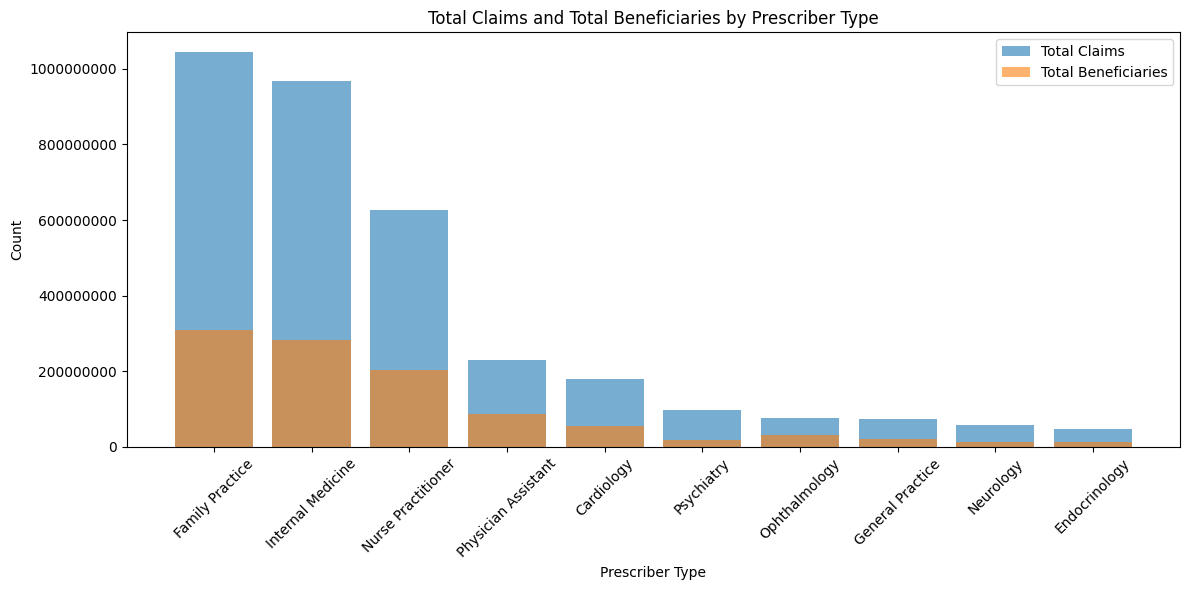

In [11]:
# plot total_claims and total_beneficiaries by prescriber type in df3
import matplotlib.ticker as mtick

plt.figure(figsize=(12, 6))
plt.bar(df3['prscrbr_type'], df3['total_claims'], label='Total Claims', alpha=0.6)
plt.bar(df3['prscrbr_type'], df3['total_beneficiaries'], label='Total Beneficiaries', alpha=0.6)
plt.xlabel('Prescriber Type')
plt.ylabel('Count')
plt.title('Total Claims and Total Beneficiaries by Prescriber Type')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.ScalarFormatter(useOffset=False))
plt.gca().ticklabel_format(style='plain', axis='y')
plt.legend()
plt.tight_layout()
plt.show()


# 4. Profile state-level prescribing across states.

In [12]:
query_4 = """
SELECT prscrbr_state_abrvtn, SUM(TOT_CLMS) AS TOTAL_CLAIMS, SUM(TOT_DRUG_CST) AS TOTAL_DRUG_COST
FROM prescribers_drug_final
GROUP BY 1
ORDER BY 3 DESC;
"""

df4 = pd.read_sql_query(query_4,engine)
df4

,prscrbr_state_abrvtn,total_claims,total_drug_cost
0,CA,360767132,5.514848e+10
1,NY,259477239,4.613732e+10
2,FL,310493741,4.136007e+10
3,TX,264686421,3.890344e+10
4,PA,199568719,2.757807e+10
...,...,...,...
57,AE,71139,1.038895e+07
58,MP,21117,1.505782e+06
59,AA,8222,2.817630e+05
60,AS,188,1.105032e+04


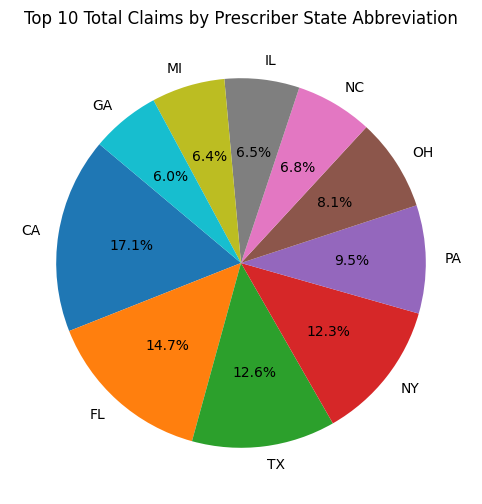

In [42]:
# pie chart of top 10 total_claims by prscrbr_state_abrvtn

top_10_states = df4.nlargest(10, 'total_claims')
plt.figure(figsize=(12, 6))
plt.pie(top_10_states['total_claims'], labels=top_10_states['prscrbr_state_abrvtn'], autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Total Claims by Prescriber State Abbreviation')
plt.show()

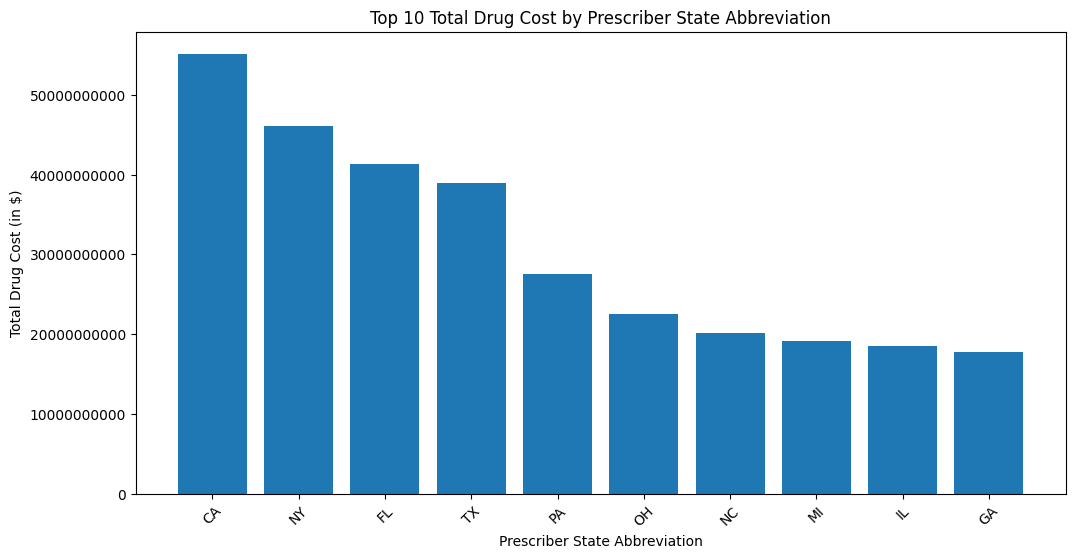

In [48]:
# top 10 states of total_drug_cost
import matplotlib.ticker as mtick

top_10_states = df4.nlargest(10, 'total_drug_cost')
plt.figure(figsize=(12, 6))
plt.bar(top_10_states['prscrbr_state_abrvtn'], top_10_states['total_drug_cost'])
plt.title('Top 10 Total Drug Cost by Prescriber State Abbreviation')
plt.xlabel('Prescriber State Abbreviation')
plt.ylabel('Total Drug Cost (in $)')
plt.gca().yaxis.set_major_formatter(mtick.ScalarFormatter(useOffset=False))
plt.gca().ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.show()

#  5. Find drugs with highest 65+ utilization and contrast with overall.

In [49]:
query_5 = """
SELECT BRND_NAME, GNRC_NAME, SUM(Tot_Clms) AS total_claims, SUM(Tot_Drug_Cst) AS total_cost,
SUM(COALESCE(GE65_Tot_Clms,0)) AS claims_65plus, SUM(COALESCE(GE65_Tot_Drug_Cst,0)) AS cost_65plus,
ROUND(SUM(COALESCE(GE65_Tot_Clms,0))::NUMERIC/NULLIF(SUM(Tot_Clms),0) * 100, 2) AS pct_claims_from_65plus,
ROUND(SUM(COALESCE(GE65_Tot_Drug_Cst,0))::numeric/NULLIF(SUM(Tot_Drug_Cst),0) * 100, 2) AS pct_cost_from_65plus
FROM prescribers_drug_final
GROUP BY Brnd_Name, Gnrc_Name
HAVING SUM(COALESCE(GE65_Tot_Clms,0)) > 0
ORDER BY claims_65plus DESC
LIMIT 20;
"""

df5 = pd.read_sql_query(query_5,engine)
df5

,brnd_name,gnrc_name,total_claims,total_cost,claims_65plus,cost_65plus,pct_claims_from_65plus,pct_cost_from_65plus
0,Atorvastatin Calcium,Atorvastatin Calcium,191892927,2.652429e+09,137341708,1.875312e+09,71.57,70.70
1,Amlodipine Besylate,Amlodipine Besylate,134783533,1.042008e+09,86816982,6.483660e+08,64.41,62.22
2,Levothyroxine Sodium,Levothyroxine Sodium,116966546,2.016682e+09,79685021,1.326041e+09,68.13,65.75
3,Lisinopril,Lisinopril,105668617,8.442745e+08,67723710,5.242920e+08,64.09,62.10
4,Gabapentin,Gabapentin,98881040,1.918381e+09,60920105,1.070328e+09,61.61,55.79
5,Losartan Potassium,Losartan Potassium,91592460,1.229877e+09,53745429,6.985637e+08,58.68,56.80
6,Omeprazole,Omeprazole,81728550,1.224561e+09,52525031,7.556311e+08,64.27,61.71
7,Metoprolol Succinate,Metoprolol Succinate,81133434,1.687620e+09,50362112,1.005584e+09,62.07,59.59
8,Metformin Hcl,Metformin Hcl,70363350,6.119269e+08,44231186,3.654663e+08,62.86,59.72
9,Furosemide,Furosemide,66381250,4.096628e+08,40574069,2.380295e+08,61.12,58.10


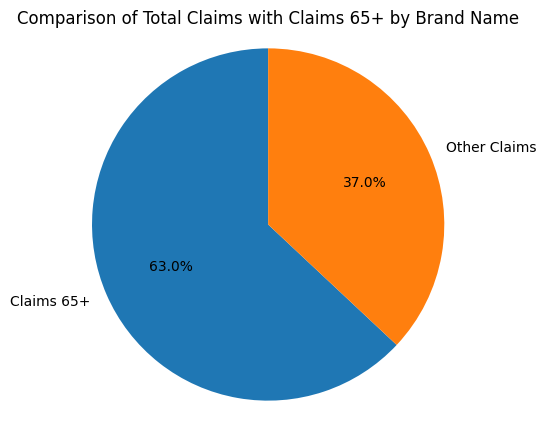

In [58]:
import matplotlib.ticker as mtick

claims_65plus = df5['claims_65plus'].sum()
total_claims = df5['total_claims'].sum()

plt.figure(figsize=(5,5))
plt.pie([claims_65plus, total_claims - claims_65plus], labels=['Claims 65+', 'Other Claims'], autopct='%1.1f%%', startangle=90)
plt.title('Comparison of Total Claims with Claims 65+ by Brand Name')
plt.axis('equal')
plt.show()


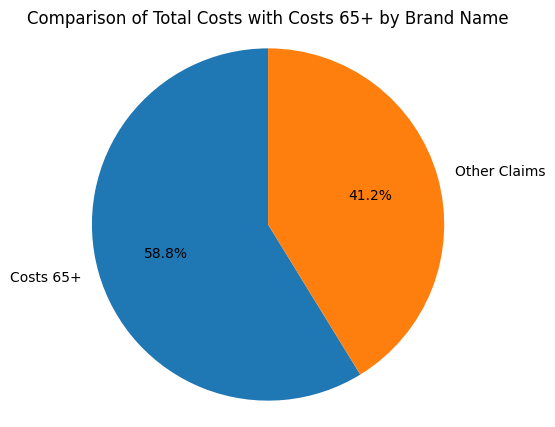

In [59]:
import matplotlib.ticker as mtick

claims_65plus = df5['cost_65plus'].sum()
total_claims = df5['total_cost'].sum()

plt.figure(figsize=(5,5))
plt.pie([claims_65plus, total_claims - claims_65plus], labels=['Costs 65+', 'Other Claims'], autopct='%1.1f%%', startangle=90)
plt.title('Comparison of Total Costs with Costs 65+ by Brand Name')
plt.axis('equal')
plt.show()

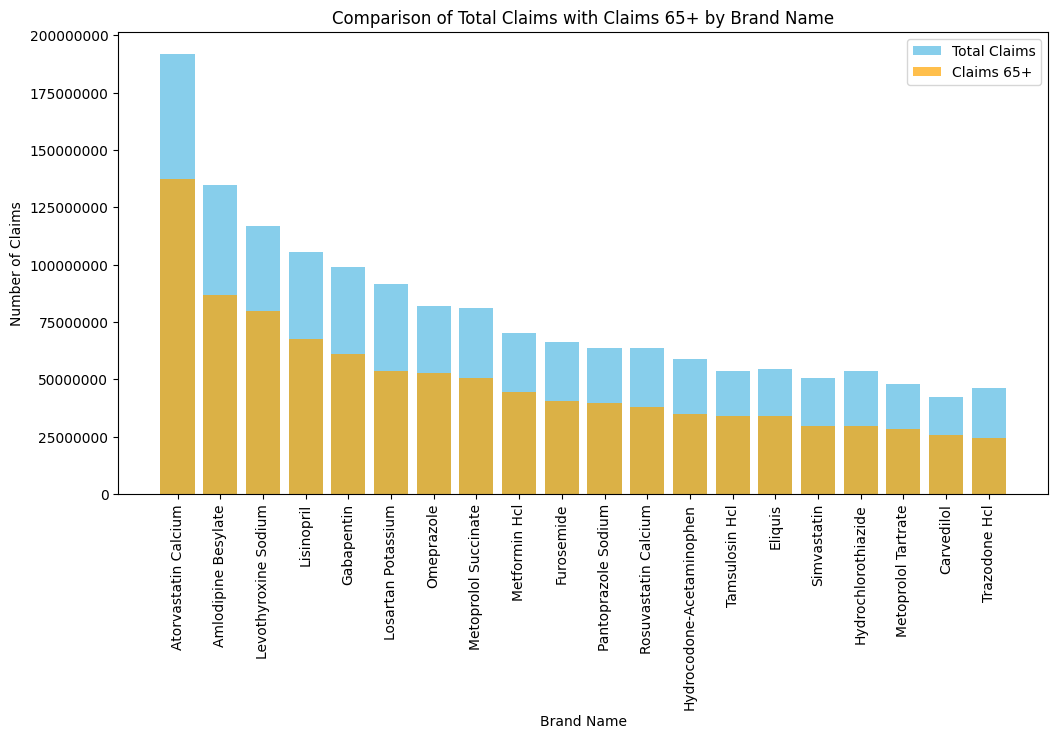

In [57]:
# plot of comparison of total_claims with claims_65plus by brnd_name
import matplotlib.ticker as mtick

plt.figure(figsize=(12, 6))
plt.bar(df5['brnd_name'], df5['total_claims'], label='Total Claims', color='skyblue')
plt.bar(df5['brnd_name'], df5['claims_65plus'], label='Claims 65+', color='orange', alpha=0.7)
plt.title('Comparison of Total Claims with Claims 65+ by Brand Name')
plt.xlabel('Brand Name')
plt.ylabel('Number of Claims')
plt.xticks(rotation=90)
plt.legend()
plt.gca().yaxis.set_major_formatter(mtick.ScalarFormatter(useOffset=False))
plt.gca().ticklabel_format(style='plain', axis='y')
plt.show()

# 6. Flag high-cost drugs via average cost per beneficiary.

In [60]:
query_6 = """
SELECT BRND_NAME, GNRC_NAME, SUM(Tot_Drug_Cst) AS total_cost, SUM(Tot_Benes) AS total_beneficiaries,
ROUND(SUM(Tot_Drug_Cst)::numeric/NULLIF(SUM(Tot_Benes),0),2) AS avg_cost_per_beneficiary
FROM prescribers_drug_final
GROUP BY Brnd_Name, Gnrc_Name
HAVING SUM(Tot_Benes)>0
ORDER BY avg_cost_per_beneficiary DESC
LIMIT 20;
"""

df6 = pd.read_sql_query(query_6,engine)
df6

,brnd_name,gnrc_name,total_cost,total_beneficiaries,avg_cost_per_beneficiary
0,Revcovi,Elapegademase-Lvlr,6.107334e+07,65,939589.83
1,Cablivi,Caplacizumab-Yhdp,8.041598e+06,15,536106.55
2,Strensiq,Asfotase Alfa,5.446084e+08,1255,433950.94
3,Myalept,Metreleptin,3.668918e+07,90,407657.59
4,Amvuttra,Vutrisiran Sodium,2.198022e+07,55,399640.36
5,Berinert,C1 Esterase Inhibitor,7.046450e+07,185,380889.21
6,Exondys-51,Eteplirsen,6.422515e+07,175,367000.84
7,Xenpozyme,Olipudase Alfa-Rpcp,3.603223e+06,10,360322.29
8,Ruconest,"C1 Esterase Inhibitor, Recomb",7.918208e+07,220,359918.54
9,Kalbitor,Ecallantide,5.715018e+07,160,357188.64


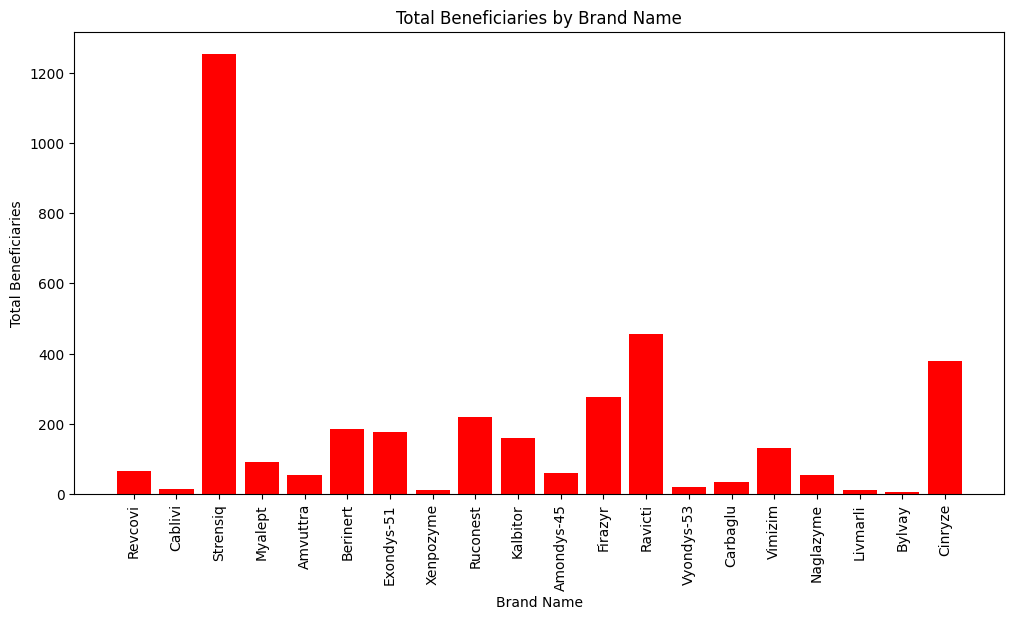

In [66]:
# plot total_beneficiaries by brnd_name
import matplotlib.ticker as mtick

plt.figure(figsize=(12, 6))
plt.bar(df6['brnd_name'], df6['total_beneficiaries'], color='red')
plt.title('Total Beneficiaries by Brand Name')
plt.xlabel('Brand Name')
plt.ylabel('Total Beneficiaries')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(mtick.ScalarFormatter(useOffset=False))
plt.gca().ticklabel_format(style='plain', axis='y')
plt.show()

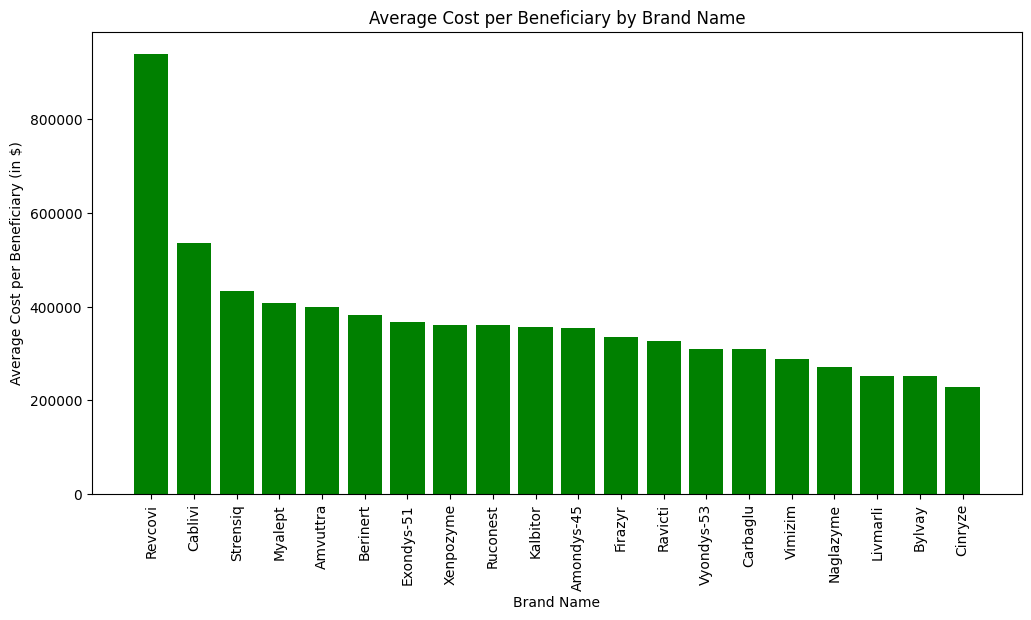

In [63]:
# plot avg_cost_per_beneficiary by brnd_name
import matplotlib.ticker as mtick

plt.figure(figsize=(12, 6))
plt.bar(df6['brnd_name'], df6['avg_cost_per_beneficiary'], color='green')
plt.title('Average Cost per Beneficiary by Brand Name')
plt.xlabel('Brand Name')
plt.ylabel('Average Cost per Beneficiary (in $)')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(mtick.ScalarFormatter(useOffset=False))
plt.gca().ticklabel_format(style='plain', axis='y')
plt.show()

# 7. Rank prescribers by unique beneficiaries served, with drill-down by drug type.

In [38]:
query_7 = """
SELECT
    Prscrbr_NPI,
    COALESCE(MAX(Prscrbr_First_Name), '') AS first_name,
    COALESCE(MAX(Prscrbr_Last_Org_Name), '') AS last_org_name,
    SUM(COALESCE(Tot_Benes,0)) AS approx_beneficiaries
FROM prescribers_drug_all
GROUP BY Prscrbr_NPI
ORDER BY approx_beneficiaries DESC
LIMIT 20;   -- top 20 prescribers
"""

df7 = pd.read_sql_query(query_7,engine)
df7

,prscrbr_npi,first_name,last_org_name,approx_beneficiaries
0,1639279417,Armaghan,Azad,969466
1,1356534994,Cedric,Davis,829523
2,1649365529,Rushdi,Alul,430573
3,1992764591,Daniel,Bauer,386900
4,1538169388,Stephanie,Han,383362
5,1265429617,John,Bogdasarian,381843
6,1699718031,Annette,Wagner,331834
7,1972641074,Marc,Watkins,319367
8,1003840778,Ruth,Mays,316943
9,1821068420,Ikenna,Nzeogu,304398


C:\Users\Abhishek\AppData\Local\Temp\ipykernel_29716\2298282478.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




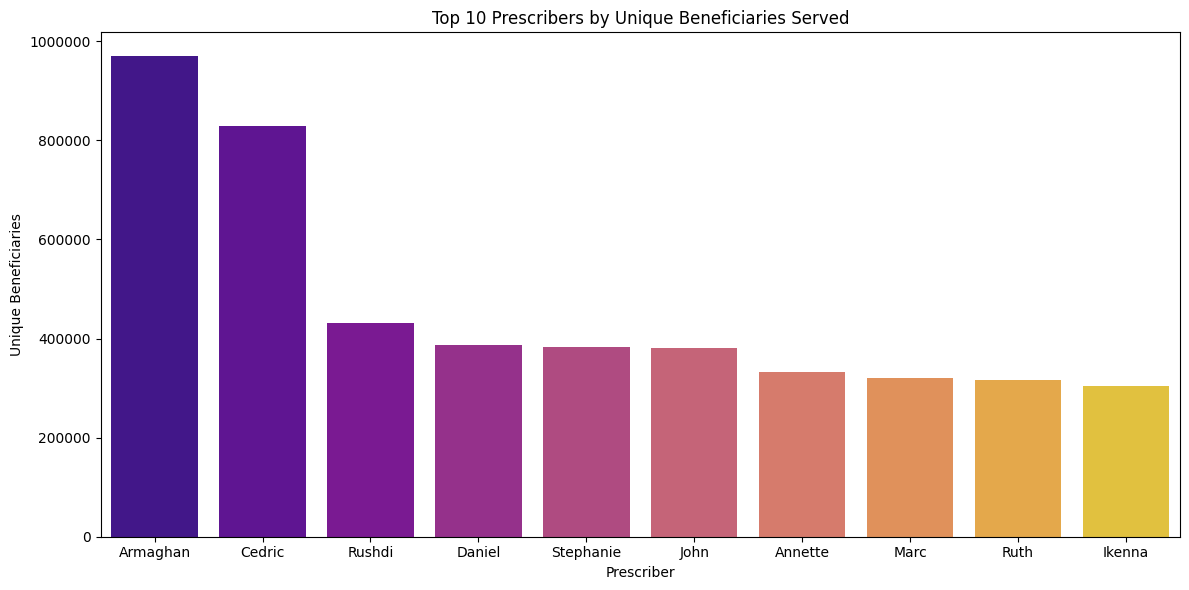

In [42]:
import matplotlib.ticker as mtick
top10 = df7.sort_values("approx_beneficiaries", ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x="first_name", y="approx_beneficiaries", data=top10,palette="plasma")
plt.title("Top 10 Prescribers by Unique Beneficiaries Served")
plt.xlabel("Prescriber")
plt.ylabel("Unique Beneficiaries")
plt.gca().yaxis.set_major_formatter(mtick.ScalarFormatter(useOffset=False))
plt.gca().ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()


# 8. Compare cost distribution across specialties, highlighting outliers via percentiles/window stats.

## Objective 8A: Total drug cost by provider specialty


In [4]:
query_8a = """
SELECT Prscrbr_Type,SUM(Tot_Drug_Cst) AS total_cost,AVG(Tot_Drug_Cst) AS avg_cost_per_record
FROM prescribers_drug_all
GROUP BY Prscrbr_Type
ORDER BY total_cost DESC;
"""

df8a = pd.read_sql_query(query_8a,engine)
df8a

,prscrbr_type,total_cost,avg_cost_per_record
0,Internal Medicine,9.045421e+10,5370.832853
1,Nurse Practitioner,8.122867e+10,5321.839573
2,Family Practice,7.621222e+10,3814.403413
3,Hematology-Oncology,4.014485e+10,72565.923320
4,Cardiology,3.053423e+10,14242.115938
...,...,...,...
191,Dental Therapist,2.748200e+02,68.705000
192,Audiologist,2.305800e+02,230.580000
193,Occupational Therapy Assistant,2.042800e+02,204.280000
194,"Assistant, Podiatric",1.178900e+02,117.890000


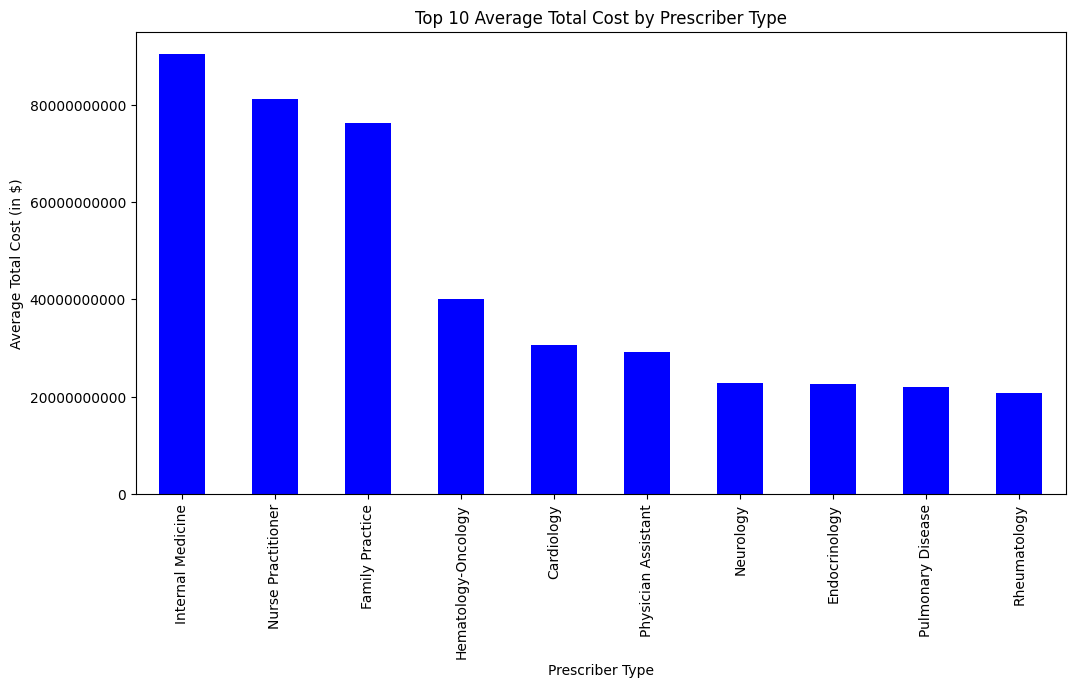

In [15]:
# plot of top 10 prscrbr_type by total_cost
import matplotlib.ticker as mtick
top_10_avg_cost_by_total = df8a.groupby('prscrbr_type')['total_cost'].mean().nlargest(10)

plt.figure(figsize=(12, 6))
top_10_avg_cost_by_total.plot(kind='bar', color='blue')
plt.title('Top 10 Average Total Cost by Prescriber Type')
plt.xlabel('Prescriber Type')
plt.ylabel('Average Total Cost (in $)')
plt.gca().yaxis.set_major_formatter(mtick.ScalarFormatter(useOffset=False))
plt.gca().ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.show()


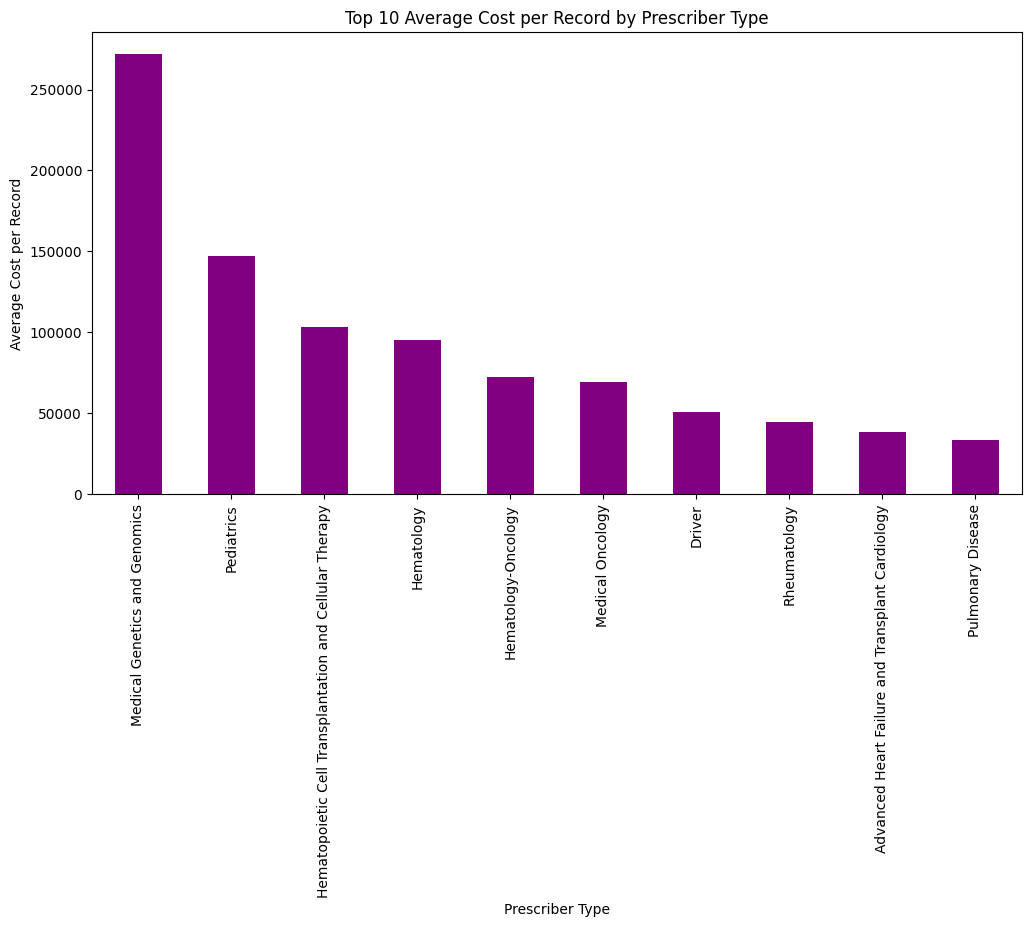

In [16]:
# plot of top 10 avg_cost_per_record by prscrbr_type
top_10_avg_cost_by_type = df8a.groupby('prscrbr_type')['avg_cost_per_record'].mean().nlargest(10)

plt.figure(figsize=(12, 6))
top_10_avg_cost_by_type.plot(kind='bar', color='purple')
plt.title('Top 10 Average Cost per Record by Prescriber Type')
plt.xlabel('Prescriber Type')
plt.ylabel('Average Cost per Record')
plt.xticks(rotation=90)
plt.show()



## Objective 8B: Detect high-cost specialties compared to others

In [5]:
query_8b = """
WITH specialty_costs AS (
    SELECT Prscrbr_Type, SUM(Tot_Drug_Cst) AS total_cost
    FROM prescribers_drug_all
    GROUP BY Prscrbr_Type
),
quartiles AS (
    SELECT
        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY total_cost) AS p25,
        PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY total_cost) AS median,
        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY total_cost) AS p75
    FROM specialty_costs
)
SELECT
    s.Prscrbr_Type,s.total_cost,q.p25,q.median,q.p75
FROM specialty_costs s
CROSS JOIN quartiles q
ORDER BY s.total_cost DESC;
"""

df8b = pd.read_sql_query(query_8b, engine)
df8b

,prscrbr_type,total_cost,p25,median,p75
0,Internal Medicine,9.045421e+10,44494.7275,2249366.97,2.459769e+08
1,Nurse Practitioner,8.122867e+10,44494.7275,2249366.97,2.459769e+08
2,Family Practice,7.621222e+10,44494.7275,2249366.97,2.459769e+08
3,Hematology-Oncology,4.014485e+10,44494.7275,2249366.97,2.459769e+08
4,Cardiology,3.053423e+10,44494.7275,2249366.97,2.459769e+08
...,...,...,...,...,...
191,Dental Therapist,2.748200e+02,44494.7275,2249366.97,2.459769e+08
192,Audiologist,2.305800e+02,44494.7275,2249366.97,2.459769e+08
193,Occupational Therapy Assistant,2.042800e+02,44494.7275,2249366.97,2.459769e+08
194,"Assistant, Podiatric",1.178900e+02,44494.7275,2249366.97,2.459769e+08


# 9. For each state and specialty, list the most-prescribed brand  by claims.

In [6]:
query_9 = """
WITH drug_totals AS (
    SELECT Prscrbr_State_Abrvtn AS state,Prscrbr_Type,Brnd_Name,SUM(Tot_Clms) AS total_claims
    FROM prescribers_drug_all
    GROUP BY Prscrbr_State_Abrvtn, Prscrbr_Type, Brnd_Name
),
ranked AS (
    SELECT state,Prscrbr_Type,Brnd_Name,total_claims,
        ROW_NUMBER() OVER (PARTITION BY state, Prscrbr_Type ORDER BY total_claims DESC) AS RN
    FROM drug_totals
)
SELECT state,Prscrbr_Type,Brnd_Name,total_claims,RN
FROM ranked
WHERE rn = 1   -- pick only the top drug in each state & specialty
ORDER BY state,total_claims DESC;
"""

df9 = pd.read_sql_query(query_9, engine)
df9

,state,prscrbr_type,brnd_name,total_claims,rn
0,AA,Dentist,Amoxicillin,2029,1
1,AA,Pharmacist,Warfarin Sodium,154,1
2,AA,Nurse Practitioner,Atorvastatin Calcium,112,1
3,AA,Oral Surgery (Dentist only),Amoxicillin,108,1
4,AA,Hospitalist,Atorvastatin Calcium,99,1
...,...,...,...,...,...
5215,ZZ,Medical Oncology,Alendronate Sodium,15,1
5216,ZZ,Orthopaedic Surgery,Oxycodone-Acetaminophen,14,1
5217,ZZ,Thoracic Surgery (Cardiothoracic Vascular Surg...,Metformin Hcl Er,14,1
5218,ZZ,Preventive Medicine,Amoxicillin-Clavulanate Potass,13,1


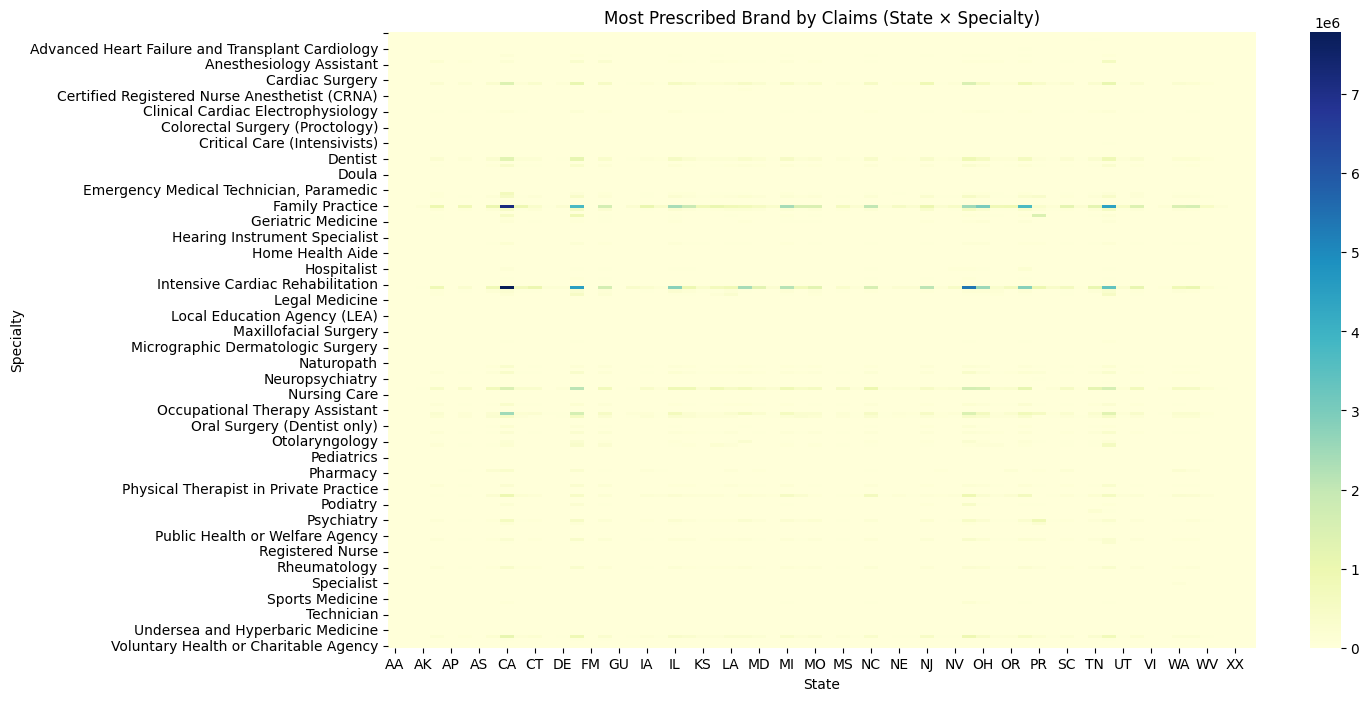

In [25]:
pivot = df9.pivot(index="prscrbr_type", columns="state", values="total_claims").fillna(0)

plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap="YlGnBu")
plt.title("Most Prescribed Brand by Claims (State × Specialty)")
plt.xlabel("State")
plt.ylabel("Specialty")
plt.show()


In [26]:
import plotly.express as px

fig = px.scatter_geo(df9,
    locations="state",
    locationmode="USA-states",
    size="total_claims",
    color="prscrbr_type",
    hover_name="brnd_name",
    scope="usa",
    title="Most Prescribed Brand by State & Specialty"
)
fig.show()
